In [2]:
import matplotlib.pyplot as plt
import numpy             as np
import torch
import copy
import matplotlib

matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from astropy     import units, constants
from pomme.model import TensorModel, SphericalModel
from pomme.loss  import Loss, diff_loss
from pomme.plot  import plot_cube_2D
from pomme.utils import planck, T_CMB

from glob import glob

In [3]:
import numpy as np
import torch

from astropy     import units, constants
from pomme.lines import Line
from pomme.loss  import Loss, diff_loss
from pomme.model import TensorModel, SphericalModel
from pomme.utils import planck, T_CMB


n_elements = 1024

r_in   = (1.0e-1 * units.au).si.value
r_out  = (1.0e+4 * units.au).si.value

v_in  = (1.0e-1 * units.km / units.s).si.value
v_inf = (2.0e+1 * units.km / units.s).si.value
beta  = 0.5

T_in    = (2.5e+3 * units.K).si.value
epsilon = 0.6

Mdot   = (5.0e-6 * units.M_sun / units.yr).si.value
v_turb = (1.0e+0 * units.km    / units.s ).si.value
T_star = (2.5e+3 * units.K               ).si.value
R_star = (1.0e+0 * units.au              ).si.value

model = TensorModel(sizes=r_out, shape=n_elements)

rs = np.logspace(np.log10(r_in), np.log10(r_out), n_elements, dtype=np.float64)

v = np.empty_like(rs)
v[rs <= R_star] = 0.0
v[rs >  R_star] = v_in + (v_inf - v_in) * (1.0 - R_star / rs[rs > R_star])**beta


################################################################
# Gaussian bump in mass-loss rate
################################################################
# r_shell = 0.001 * r_out
# width   = 0.200 * r_shell
# Mdot = Mdot * (1.0 + 10.0 * np.exp(-0.5*((rs-r_shell)/width)**2))
################################################################


rho  = Mdot / (4.0 * np.pi * rs**2 * v)
n_CO = (3.0e-4 * constants.N_A.si.value / 2.02e-3) * rho
n_CO[rs<=R_star] = n_CO[n_CO<np.inf].max()


# Define and initialise the model variables
model['log_r'         ] = np.log(rs)
model['log_CO'        ] = np.log(n_CO)
model['log_turbulence'] = np.log(v_turb) * np.ones(n_elements)
model['log_v_in'      ] = np.log(v_in)
model['log_v_inf'     ] = np.log(v_inf)
model['log_beta'      ] = np.log(beta)
model['log_T_in'      ] = np.log(T_in)
model['log_epsilon'   ] = np.log(epsilon)
model['log_T_star'    ] = np.log(T_star)
model['log_R_star'    ] = np.log(R_star)

model.fix_all()
model.save('model_truth.h5')

# Line data
lines = [Line('CO', i) for i in [2, 6]]

# Frequency data
vdiff = 500   # velocity increment size [m/s]
nfreq =  50   # number of frequencies

velocities  = nfreq * vdiff * torch.linspace(-1, +1, nfreq, dtype=torch.float64)
frequencies = [(1.0 + velocities / constants.c.si.value) * line.frequency for line in lines]

/tmp/ipykernel_752954/4183053745.py:46: RuntimeWarning: divide by zero encountered in true_divide
  rho  = Mdot / (4.0 * np.pi * rs**2 * v)
/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=7-6)
Please check the properties that were inferred:
    Frequency         8.066518060e+11  Hz
    Einstein A coeff  3.422000000e-05  1/s
    Molar mass        28.0101          g/mol


In [4]:
def get_velocity(model):
    """
    Get the velocity from the TensorModel.
    """
    # Extract parameters
    r      = torch.exp(model['log_r'])
    v_in   = torch.exp(model['log_v_in'])
    v_inf  = torch.exp(model['log_v_inf'])
    beta   = torch.exp(model['log_beta'])
    R_star = torch.exp(model['log_R_star'])
    # Compute velocity
    v = torch.empty_like(r)
    v[r <= R_star] = v_in
    v[r >  R_star] = v_in + (v_inf - v_in) * (1.0 - R_star / r[r > R_star])**beta
    # Return
    return v


def get_temperature(model):
    """
    Get the temperature from the TensorModel.
    """
    # Extract parameters
    r       = torch.exp(model['log_r'])
    T_in    = torch.exp(model['log_T_in'])
    epsilon = torch.exp(model['log_epsilon'])
    R_star  = torch.exp(model['log_R_star'])
    # Compute temperature
    T = torch.empty_like(r)    
    T[r <= R_star] = T_in
    T[r >  R_star] = T_in * (R_star / r[r > R_star])**epsilon
    # Return
    return T


def get_abundance(model):
    """
    Get the abundance from the TensorModel.
    """
    return torch.exp(model['log_CO'])


def get_turbulence(model):
    """
    Get the turbulence from the TensorModel.
    """
    return torch.exp(model['log_turbulence'])


def get_boundary_condition(model, frequency, b):
    """
    Get the boundary condition from the TensorModel.
    """
    # Extract parameters
    T_star = torch.exp(model['log_T_star'])
    R_star = torch.exp(model['log_R_star'])
    # Compute boundary condition
    if b > R_star:
        return planck(temperature=T_CMB, frequency=frequency)
    else:
        return planck(temperature=T_star, frequency=frequency)

In [5]:
model_truth = TensorModel.load('model_truth.h5')

smodel_truth = SphericalModel(rs, model_truth, r_star=R_star)
smodel_truth.get_velocity           = get_velocity
smodel_truth.get_abundance          = get_abundance
smodel_truth.get_turbulence         = get_turbulence
smodel_truth.get_temperature        = get_temperature
smodel_truth.get_boundary_condition = get_boundary_condition

In [6]:
obss = smodel_truth.image(lines, frequencies, r_max=r_out)

In [7]:
model_noco = TensorModel.load('model.h5')

smodel_noco = SphericalModel(rs, model_noco, r_star=R_star)
smodel_noco.get_velocity           = get_velocity
smodel_noco.get_abundance          = get_abundance
smodel_noco.get_turbulence         = get_turbulence
smodel_noco.get_temperature        = get_temperature
smodel_noco.get_boundary_condition = get_boundary_condition

In [8]:
model_cont = TensorModel.load('model_cont.h5')

smodel_cont = SphericalModel(rs, model_cont, r_star=R_star)
smodel_cont.get_velocity           = get_velocity
smodel_cont.get_abundance          = get_abundance
smodel_cont.get_turbulence         = get_turbulence
smodel_cont.get_temperature        = get_temperature
smodel_cont.get_boundary_condition = get_boundary_condition

In [9]:
model_nono = TensorModel.load('model_nodiff.h5')

smodel_nono = SphericalModel(rs, model_nono, r_star=R_star)
smodel_nono.get_velocity           = get_velocity
smodel_nono.get_abundance          = get_abundance
smodel_nono.get_turbulence         = get_turbulence
smodel_nono.get_temperature        = get_temperature
smodel_nono.get_boundary_condition = get_boundary_condition

In [10]:
obss.shape

torch.Size([2, 50])

In [11]:
imgs_noco = torch.load('imgs.pt')
imgs_cont = torch.load('imgs_cont.pt')
imgs_nono = torch.load('imgs_nodiff.pt')

In [12]:
mask = (rs >= (1.0 * units.au).si.value)

In [13]:
mask

array([False, False, False, ...,  True,  True,  True])

In [14]:
# rs = rs[mask]

In [15]:
smodel_nono .get_abundance(smodel_nono .model_1D).shape

torch.Size([1024])

In [16]:
mask.shape

(1024,)

In [17]:
smodel_noco .get_abundance(smodel_noco .model_1D).shape

torch.Size([1024])

In [18]:
rs.shape

(1024,)

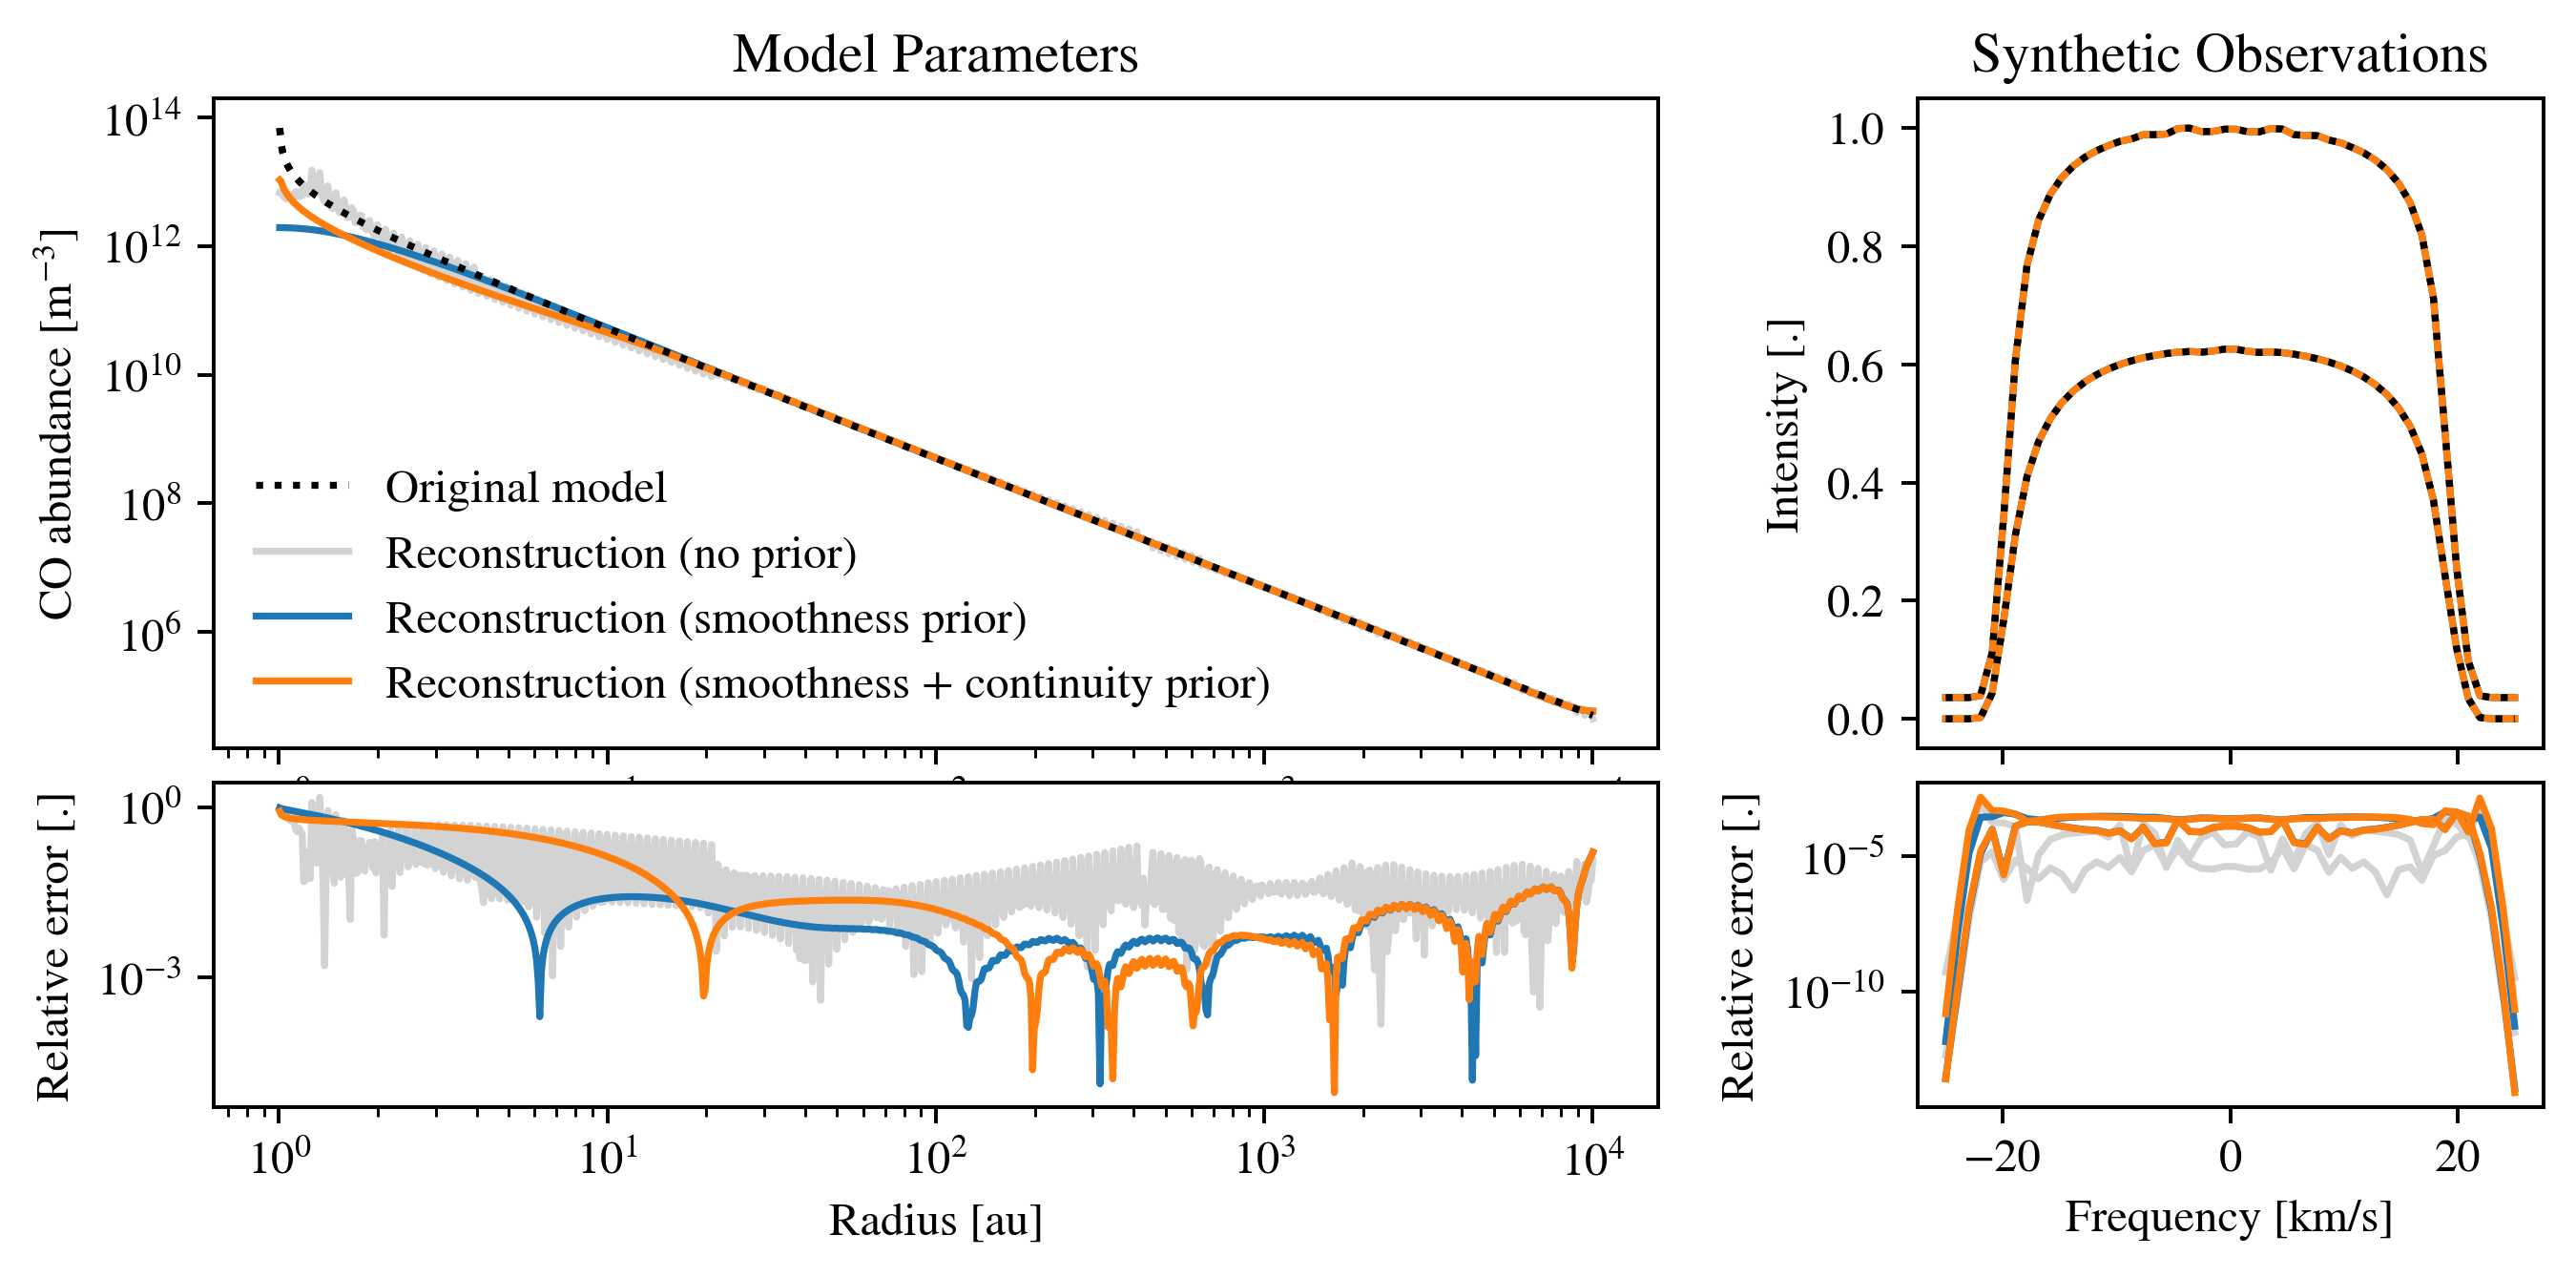

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=2, dpi=350, figsize=(9,4), gridspec_kw={'width_ratios':[3,1.3], 'height_ratios':[2,1], 'wspace':0.25, 'hspace':0.07})

axs[0,0].set_title('Model Parameters')
axs[0,0].plot(rs[mask] / (1.0 * units.au).si.value, smodel_truth.get_abundance(smodel_truth.model_1D).data[mask], c='k', linestyle=':', label='Original model')
axs[0,0].plot(rs[mask] / (1.0 * units.au).si.value, smodel_nono .get_abundance(smodel_nono .model_1D).data[mask], c='lightgrey',        label='Reconstruction (no prior)')
axs[0,0].plot(rs[mask] / (1.0 * units.au).si.value, smodel_noco .get_abundance(smodel_noco .model_1D).data[mask], c='tab:blue',         label='Reconstruction (smoothness prior)')
axs[0,0].plot(rs[mask] / (1.0 * units.au).si.value, smodel_cont .get_abundance(smodel_cont .model_1D).data[mask], c='tab:orange',       label='Reconstruction (smoothness + continuity prior)')
axs[0,0].plot(rs[mask] / (1.0 * units.au).si.value, smodel_truth.get_abundance(smodel_truth.model_1D).data[mask], c='k', linestyle=':')
axs[0,0].set_xticklabels([])
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_ylabel(r'CO abundance [m$^{-3}$]')
# axs[0,0].set_xlabel(r'Radius [$\times 10^{3}$ au]')
axs[0,0].legend(frameon=False, loc='lower left')

tr = smodel_truth.get_abundance(smodel_truth.model_1D).data[mask]

axs[1,0].plot(rs[mask] / (1.0 * units.au).si.value, abs(smodel_nono .get_abundance(smodel_nono .model_1D).data[mask]-tr)/tr, c='lightgrey')
axs[1,0].plot(rs[mask] / (1.0 * units.au).si.value, abs(smodel_noco .get_abundance(smodel_noco .model_1D).data[mask]-tr)/tr, c='tab:blue')
axs[1,0].plot(rs[mask] / (1.0 * units.au).si.value, abs(smodel_cont .get_abundance(smodel_cont .model_1D).data[mask]-tr)/tr, c='tab:orange')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel(r'Relative error [.]')
axs[1,0].set_xlabel(r'Radius [au]')

# # plt.title("Model & Reconstruction")
axs[0,1].set_title('Synthetic Observations')
axs[0,1].plot(velocities/1.0e+3, (imgs_nono[0]/obss[0].max()).data, c='lightgrey')
axs[0,1].plot(velocities/1.0e+3, (imgs_nono[1]/obss[0].max()).data, c='lightgrey')
axs[0,1].plot(velocities/1.0e+3, (imgs_noco[0]/obss[0].max()).data, c='tab:blue')
axs[0,1].plot(velocities/1.0e+3, (imgs_noco[1]/obss[0].max()).data, c='tab:blue')
axs[0,1].plot(velocities/1.0e+3, (imgs_cont[0]/obss[0].max()).data, c='tab:orange')
axs[0,1].plot(velocities/1.0e+3, (imgs_cont[1]/obss[0].max()).data, c='tab:orange')
axs[0,1].plot(velocities/1.0e+3, (obss     [0]/obss[0].max()).data, c='k', linestyle=':')
axs[0,1].plot(velocities/1.0e+3, (obss     [1]/obss[0].max()).data, c='k', linestyle=':')
axs[0,1].set_ylabel(r"Intensity [.]")
axs[0,1].set_xlabel(r"Frequency [km/s]")
axs[0,1].set_xticklabels([])

tr0 = (obss[0]/obss[0].max()).data 
tr1 = (obss[1]/obss[0].max()).data 

axs[1,1].plot(velocities/1.0e+3, abs((imgs_nono[0]/obss[0].max()).data-tr0)/tr0, c='lightgrey')
axs[1,1].plot(velocities/1.0e+3, abs((imgs_nono[1]/obss[0].max()).data-tr1)/tr1, c='lightgrey')
axs[1,1].plot(velocities/1.0e+3, abs((imgs_noco[0]/obss[0].max()).data-tr0)/tr0, c='tab:blue')
axs[1,1].plot(velocities/1.0e+3, abs((imgs_noco[1]/obss[0].max()).data-tr1)/tr1, c='tab:blue')
axs[1,1].plot(velocities/1.0e+3, abs((imgs_cont[0]/obss[0].max()).data-tr0)/tr0, c='tab:orange')
axs[1,1].plot(velocities/1.0e+3, abs((imgs_cont[1]/obss[0].max()).data-tr1)/tr1, c='tab:orange')
axs[1,1].set_xlabel(r"Frequency [km/s]")
axs[1,1].set_ylabel(r'Relative error [.]')
axs[1,1].set_yscale('log')

plt.savefig('1D_only_CO.pdf', bbox_inches='tight')